In [3]:
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

### This notebook is to explore basic SOMs/LVQ

# 1) Self Organized Maps

Some helper functions

In [4]:
def generate_points_in_triangle(n,s = 1):

    init_sampled_points = s*np.random.rand(n,2)

    points_in_region = []

    for point in init_sampled_points:

        x,y = point

        if y < 0:
            continue

        elif y > x:
            continue

        elif y > -x+s:
            continue

        points_in_region.append(point)

    return np.array(points_in_region)

In [5]:
def initialize_protypes(data,n_prototypes):

    rand_indices = np.random.randint(low = 0, high = len(data), size = n_prototypes)
    
    prototype_vectors = data[rand_indices]
    
    return prototype_vectors


In [6]:
def gain_function(t,c,total_iterations):

    gain_t = c * (1 - (t/total_iterations))

    return gain_t

In [7]:
def SOM(
    data,initial_prototypes,total_iterations,c):

    n_data_points = len(data)

    SOM_prototypes = copy.deepcopy(initial_prototypes)

    for t in range(total_iterations):
    
        rand_idx =  np.random.randint(n_data_points)
    
        x_t = data[rand_idx]
    
        distances = np.linalg.norm(x_t - SOM_prototypes,axis = 1)**2
        idx_of_bmu = np.argmin(distances)
    
        mc_t = SOM_prototypes[idx_of_bmu]
    
        alpha_t = gain_function(t,c,total_iterations)
    
        correction_amount = alpha_t * (x_t - mc_t)    
        
        mc_t += correction_amount

    return SOM_prototypes

In [8]:
def LVQ1(X,y,prototypes,prototype_labels,total_iterations,c):
    
    n_data_points = len(X)

    LVQ1_prototypes = copy.deepcopy(prototypes)
    
    for t in range(total_iterations):
    
        rand_idx =  np.random.randint(n_data_points)
        
        x_t = X[rand_idx]
        
        distances = np.linalg.norm(x_t - LVQ1_prototypes,axis = 1)**2
        distance_idxs_sorted = np.argsort(distances)
        idx_of_closest_prototype = distance_idxs_sorted[0]
    
        predicted_label = prototype_labels[idx_of_closest_prototype]
        correct_label = y[rand_idx]
    
        alpha_t = gain_function(t,c,total_iterations)
    
        mc_t = LVQ1_prototypes[idx_of_closest_prototype]
        
        if predicted_label == correct_label:
    
            update_direction = alpha_t * (x_t - mc_t)
            mc_t += update_direction
    
        else:
            update_direction = -alpha_t * (x_t - mc_t)
            mc_t += update_direction

    return LVQ1_prototypes


In [9]:
def assign_labels_to_prototypes(X,y,prototypes,majority_vote_size = 10):

    assigned_labels = np.ones(len(prototypes))

    for i,p in enumerate(prototypes):

        distances_to_points = np.linalg.norm(X - p,axis = 1)**2

        sorted_distance_idxs = np.argsort(distances_to_points)

        labels_of_closest_points = y[sorted_distance_idxs][:majority_vote_size]

        majority_vote_label = np.argmax(np.bincount(labels_of_closest_points))

        assigned_labels[i] = majority_vote_label

    return assigned_labels.astype(dtype = 'int32')

In [10]:
def assign_predicted_labels(X,prototypes,prototype_labels):

    distances = np.linalg.norm(X[:, np.newaxis, :] - prototypes[np.newaxis, :, :], axis=-1)

    closest_prototype_idxs = np.argsort(distances,axis = 1)[:,0]

    predicted_labels = prototype_labels[closest_prototype_idxs]

    return predicted_labels

Generating data

In [10]:
n_data_points = 10**4
data_scale = 10

n_prototypes = 20

sampled_data = generate_points_in_triangle(n = n_data_points,s = data_scale)
prototype_vectors = initialize_protypes(sampled_data,n_prototypes)

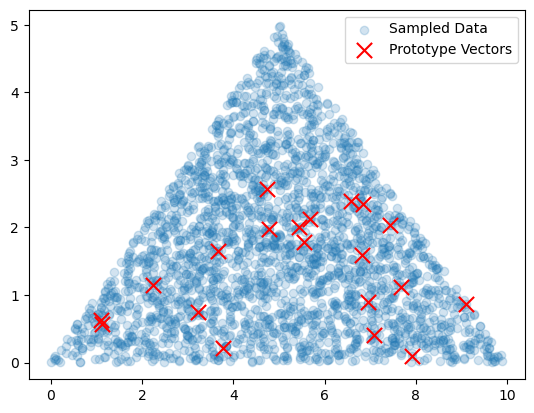

In [11]:
plt.scatter(sampled_data[:,0],sampled_data[:,1],alpha = 0.2);
plt.scatter(prototype_vectors[:,0],prototype_vectors[:,1],marker = 'x',color = 'red',s = 120)

plt.legend(['Sampled Data','Prototype Vectors'])

Updating the codebook vectors now

In [12]:
total_iterations = 1000
c = 0.5

updated_prototypes = SOM(
    sampled_data,prototype_vectors,total_iterations,c)


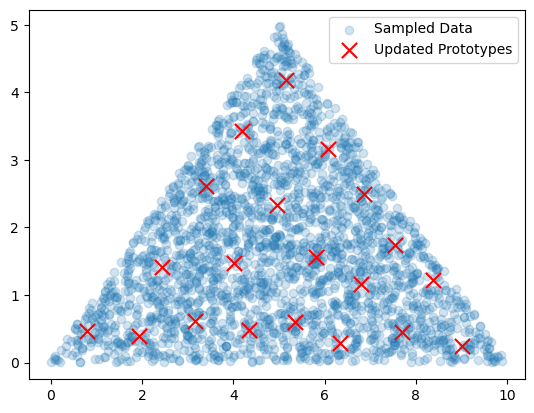

In [13]:
plt.scatter(sampled_data[:,0],sampled_data[:,1],alpha = 0.2);
plt.scatter(updated_prototypes[:,0],updated_prototypes[:,1],marker = 'x',color = 'red',s = 120)

plt.legend(['Sampled Data','Updated Prototypes'])

### Plotting Lattice of the codebook vectors after organization

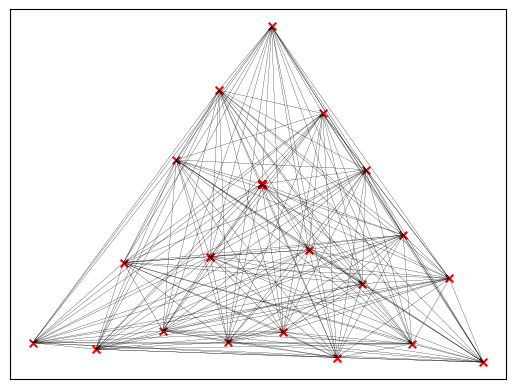

In [14]:
for i,cbv_1 in enumerate(updated_prototypes):

    x1,y1 = cbv_1
    
    for j,cbv_2 in enumerate(updated_prototypes):

        if i == j:
            continue

        x2,y2 = cbv_2

        plt.plot([x1,x2],[y1,y2],color = 'black',linewidth = 0.1)

    plt.scatter(x1,y1,color = 'red',marker = 'x',s = 30)
    plt.scatter(x2,y2,color = 'red',marker = 'x',s = 30)

plt.xticks([])
plt.yticks([]);

# 2) LVQ 1

In [11]:
from sklearn.datasets import make_classification

In [12]:
n_classes = 4
class_sep = 0.01
n_prototypes = 15

X,y = make_classification(n_samples = 200,n_features = 2,n_classes = n_classes,n_clusters_per_class=1,n_informative=2,n_redundant = 0)

In [13]:
initial_prototypes = initialize_protypes(X,n_prototypes)

total_iterations = 1000
c = 0.5

SOM_prototypes = SOM(
    X,initial_prototypes,total_iterations,c
)

The classification problem

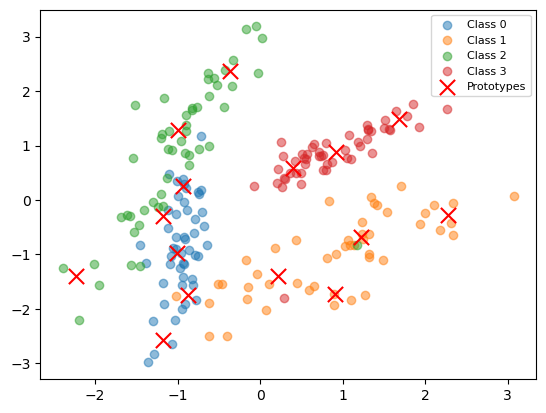

In [14]:
for class_idx in range(n_classes):

    plt.scatter(X[y == class_idx][:,0],X[y == class_idx][:,1],label = f'Class {class_idx}',alpha = 0.5)

plt.scatter(SOM_prototypes[:,0],SOM_prototypes[:,1],marker = 'x',color = 'red',s = 120,label = 'Prototypes')

plt.legend(fontsize = 8);

Assigning labels to prototypes from SOM initialization

In [15]:
assigned_labels = assign_labels_to_prototypes(
    X,y,SOM_prototypes
)

In [16]:
total_iterations = 1000

LVQ1_prototypes = LVQ1(
    X,y,SOM_prototypes,assigned_labels,total_iterations,c
)

In [17]:
som_predicted_labels = assign_predicted_labels(X,SOM_prototypes,assigned_labels)
lvq1_predicted_labels = assign_predicted_labels(X,LVQ1_prototypes,assigned_labels)

som_acc = np.sum(som_predicted_labels == y) / len(y)
lvq1_acc = np.sum(lvq1_predicted_labels == y) / len(y)

lvq1_acc,som_acc

(0.895, 0.88)

Testing for a difference across many datasets

In [22]:
n_trials = 1000

lvq1_accs = np.ones(n_trials)
som_accs = np.ones(n_trials)

for i,trial in enumerate(tqdm(range(n_trials))):

    X,y = make_classification(n_samples = 200,n_features = 2,
                              n_classes = n_classes,n_clusters_per_class=1,
                              n_informative=2,n_redundant = 0)

    initial_prototypes = initialize_protypes(X,n_prototypes)

    total_iterations = 500
    c = 0.5
    
    SOM_prototypes = SOM(
        X,initial_prototypes,total_iterations,c
    )

    assigned_labels = assign_labels_to_prototypes(
        X,y,SOM_prototypes
    )

    total_iterations = 500

    LVQ1_prototypes = LVQ1(
        X,y,SOM_prototypes,assigned_labels,total_iterations,c
    )

    som_predicted_labels = assign_predicted_labels(X,SOM_prototypes,assigned_labels)
    lvq1_predicted_labels = assign_predicted_labels(X,LVQ1_prototypes,assigned_labels)
    
    som_acc = np.sum(som_predicted_labels == y) / len(y)
    lvq1_acc = np.sum(lvq1_predicted_labels == y) / len(y)
    
    lvq1_acc,som_acc

    lvq1_accs[i] = lvq1_acc
    som_accs[i] = som_acc

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.11it/s]


In [23]:
np.mean(lvq1_accs) - np.mean(som_accs)

0.02265499999999998

# 3) Implementing GLVQ

In [79]:
from sklearn.cluster import KMeans
from sklvq import GLVQ

In [80]:
def init_with_kmeans(X,n_prototypes):

    kmeans = KMeans(n_clusters = n_prototypes).fit(X)

    initial_prototypes = kmeans.cluster_centers_

    return initial_prototypes

In [81]:
def get_accuracy(X,y,prototypes,prototype_labels):

    y_hat = assign_predicted_labels(X,prototypes,prototype_labels)

    acc = np.sum(y_hat == y) / len(y)

    return acc

    

In [94]:
n_classes = 3
class_sep = 0.5
n_prototypes = 8

X,y = make_classification(n_samples = 32,n_features = 2,n_classes = n_classes,n_clusters_per_class=1,n_informative=2,n_redundant = 0)

In [95]:
glvq = GLVQ(
    distance_type="squared-euclidean",
    activation_type="swish",
    activation_params={"beta": 2},
    solver_type="steepest-gradient-descent",
    solver_params={"max_runs": 20, "step_size": 0.1},
)

In [96]:
s = time()

glvq.fit(X,y)

e = time()

e - s

0.22058987617492676